In [22]:
import os
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms
import mlflow
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob
import torch.optim as optim
import torch.onnx
import torchvision.models as models

In [23]:

def create_center_mask(image_size, max_percentage=10):
    """
    Create a mask with a black square in the center for the region to inpaint.

    Args:
        image_size (tuple): (width, height) of the image.
        max_percentage (float): Maximum percentage of the image area covered by the square.

    Returns:
        Image: Binary mask where 1 (or 255) represents the inpainting region.
    """
    width, height = image_size
    max_area = (width * height) * (max_percentage / 100)  # Maximum area of the square
    side_length = int(max_area ** 0.5)

    # Create an empty mask
    mask = Image.new("L", (width, height), 0)  # Binary mask (0 for background)
    draw = ImageDraw.Draw(mask)

    # Define the square's position
    x0 = (width - side_length) // 2
    y0 = (height - side_length) // 2
    x1 = x0 + side_length
    y1 = y0 + side_length

    # Draw the inpainting region as white (255)
    draw.rectangle([x0, y0, x1, y1], fill=255)

    return mask

# Example: Create a mask
image_size = (224, 224)  # Replace with your image size
mask = create_center_mask(image_size, max_percentage=10)
# mask.show()  # Visualize the mask


In [24]:
normalize_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()  # Convert image to tensor with values in [0, 1]
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

In [25]:
mlflow.set_experiment("Image Inpainting with fast Autoencoder-skip")

<Experiment: artifact_location='file:///c:/Users/mmart/Documents/Studia/SEM5/CV-ImageInpainting/mlruns/537589845174326361', creation_time=1738066883943, experiment_id='537589845174326361', last_update_time=1738066883943, lifecycle_stage='active', name='Image Inpainting with fast Autoencoder-skip', tags={}>

In [26]:
import torch
import torch.nn as nn

class FastInpaintingModelWithSkip(nn.Module):
    def __init__(self):
        super(FastInpaintingModelWithSkip, self).__init__()
        
        # Encoder layers
        self.enc1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=4, stride=2, padding=1),  # Fewer filters for faster computation
            nn.ReLU(inplace=False)

        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False)

        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=False)

        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Fewer parameters in bottleneck
            nn.ReLU(inplace=False)

        )
        
        # Decoder layers with skip connections
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=False)

        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # Skip connection from enc3
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False)

        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=4, stride=2, padding=1),  # Skip connection from enc2
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False)

        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(32 + 32, 3, kernel_size=4, stride=2, padding=1),  # Skip connection from enc1
            nn.Sigmoid()  # Pixel values in [0, 1]
        )
    
    def forward(self, x):
        # Encoding path
        enc1 = self.enc1(x)  # Output: (B, 32, 112, 112)
        enc2 = self.enc2(enc1)  # Output: (B, 64, 56, 56)
        enc3 = self.enc3(enc2)  # Output: (B, 128, 28, 28)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc3)  # Output: (B, 256, 14, 14)
        
        # Decoding path with skip connections
        dec1 = self.dec1(bottleneck)  # Output: (B, 128, 28, 28)
        dec2 = self.dec2(torch.cat([dec1, enc3], dim=1))  # Skip connection from enc3
        dec3 = self.dec3(torch.cat([dec2, enc2], dim=1))  # Skip connection from enc2
        dec4 = self.dec4(torch.cat([dec3, enc1], dim=1))  # Skip connection from enc1
        
        return dec4

# Instantiate the model
model = FastInpaintingModelWithSkip()
print(model)


FastInpaintingModelWithSkip(
  (enc1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (dec1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dec2): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding

In [27]:
from torchvision.transforms import ToTensor

def combine_image_and_mask(image, mask):
    """
    Combine an image and its mask into a 4-channel input.

    Args:
        image (PIL.Image): The input image.
        mask (PIL.Image): The binary mask.

    Returns:
        Tensor: 4-channel tensor (image + mask).
    """
    image_tensor = ToTensor()(image)  # Convert image to tensor
    mask_tensor = ToTensor()(mask)  # Convert mask to tensor
    combined = torch.cat((image_tensor, mask_tensor), dim=0)  # Combine along channel dimension
    return combined





In [28]:
class InpaintingDataset(Dataset):
    def __init__(self, holed_dir, ground_truth_dir, mask, transform=None, limit=None):
        """
        Args:
            holed_dir (str): Path to the directory with holed images (e.g., HoledImages/train).
            ground_truth_dir (str): Path to the directory with ground truth images (e.g., VegetableImages/train).
            mask (PIL.Image): Precomputed binary mask for the inpainting region.
            transform (callable, optional): Optional transform to apply to the images.
            limit (int, optional): Limit the number of images used.
        """
        self.holed_paths = sorted(glob.glob(os.path.join(holed_dir, "**", "*.*"), recursive=True))
        self.ground_truth_paths = sorted(glob.glob(os.path.join(ground_truth_dir, "**", "*.*"), recursive=True))
        self.mask = transforms.ToTensor()(mask)  # Convert mask to a tensor
        self.transform = transform

        # Ensure paths match and limit dataset size if needed
        assert len(self.holed_paths) == len(self.ground_truth_paths), "Mismatch between holed and ground truth images"
        if limit:
            self.holed_paths = self.holed_paths[:limit]
            self.ground_truth_paths = self.ground_truth_paths[:limit]

    def __len__(self):
        return len(self.holed_paths)

    def __getitem__(self, idx):
        # Load the holed and ground truth images
        holed_path = self.holed_paths[idx]
        ground_truth_path = self.ground_truth_paths[idx]

        holed_image = Image.open(holed_path).convert("RGB")
        ground_truth_image = Image.open(ground_truth_path).convert("RGB")

        # Apply transforms if provided
        if self.transform:
            holed_image = self.transform(holed_image)
            ground_truth_image = self.transform(ground_truth_image)

        # Ensure the mask has the same spatial dimensions as the image
        mask_tensor = self.mask
        if mask_tensor.shape[-2:] != holed_image.shape[-2:]:
            mask_tensor = torch.nn.functional.interpolate(
                mask_tensor.unsqueeze(0), size=holed_image.shape[-2:]
            ).squeeze(0)

        # Create 4-channel input (holed image + mask)
        combined_input = torch.cat((holed_image, mask_tensor), dim=0)

        return combined_input, ground_truth_image


# Example usage
mask = create_center_mask((224, 224), max_percentage=10)
mask = create_center_mask((224, 224), max_percentage=10)

train_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/train",
    ground_truth_dir="NormalizedData/VegetableImages/train",
    mask=mask,
    transform=normalize_transform,
    limit=1000  # Use only 1000 images
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# Test the model on one image
test_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/test",
    ground_truth_dir="NormalizedData/VegetableImages/test",
    mask=mask,
    transform=normalize_transform,
    limit=100  
)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



val_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/validation",
    ground_truth_dir="NormalizedData/VegetableImages/validation",
    mask=mask,
    transform=normalize_transform
)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)




# Check the data
for combined_input, target in train_loader:
    print(f"Input shape: {combined_input.shape}, Target shape: {target.shape}")
    break


Input shape: torch.Size([64, 4, 128, 128]), Target shape: torch.Size([64, 3, 128, 128])


In [29]:
mask = create_center_mask((224, 224), max_percentage=10)
mask = create_center_mask((224, 224), max_percentage=10)

train_dataset = InpaintingDataset(
    holed_dir="NormalizedData/HoledImages/train",
    ground_truth_dir="NormalizedData/VegetableImages/train",
    mask=mask,
    transform=normalize_transform,
    limit=1000  # Use only 1000 images of beans
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)



In [30]:
loss_fn = nn.MSELoss()  # Pixel-wise MSE loss
mae_loss = nn.L1Loss()


# Perceptual Loss using Pretrained VGG16
class PerceptualLoss(nn.Module):
    def __init__(self, layers=[3, 8, 15]):  # Use VGG layers conv1_2, conv2_2, conv3_3
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features
        self.vgg_layers = nn.ModuleList([vgg[i] for i in layers]).eval()
        for param in self.vgg_layers.parameters():
            param.requires_grad = False  # Freeze VGG layers

    def forward(self, output, target):
        loss = 0.0
        for layer in self.vgg_layers:
            output = layer(output.clone())
            target = layer(target.clone())
            loss += nn.functional.mse_loss(output, target)  # Perceptual difference
        return loss

perceptual_loss = PerceptualLoss()

c:\Users\mmart\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mmart\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
def masked_loss(output, target, mask):
    """
    Compute MSE loss only for the masked region.

    Args:
        output (Tensor): Model output (B, C, H, W).
        target (Tensor): Ground truth image (B, C, H, W).
        mask (Tensor): Binary mask indicating the region to inpaint (B, 1, H, W).

    Returns:
        Tensor: Loss value.
    """
    mask = mask.to(output.device)  # Ensure mask is on the same device
    loss = ((output - target) ** 2).clone() * mask
  # Apply the mask
    return loss.sum() / mask.sum()  # Normalize by the number of pixels in the mask


In [32]:
# mlflow.end_run()

In [33]:
# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FastInpaintingModelWithSkip().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [34]:
def log_visualizations(test_loader, model, step):
    """
    Generate and save visualizations of the inpainting results to MLflow.

    Args:
        test_loader (DataLoader): Test DataLoader.
        model (torch.nn.Module): Trained inpainting model.
        step (int): Current step or epoch.
    """
    model.eval()
    with torch.no_grad():
        for idx, (combined_input, target) in enumerate(test_loader):
            combined_input, target = combined_input.to(device), target.to(device)
            output = model(combined_input)

            # Extract mask, input image, and ground truth
            input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            mask = combined_input[:, 3:4, :, :].cpu().numpy()  # (B, 1, H, W)
            target_image = target.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            output_image = output.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)

            # Rescale images for visualization
            input_image = (input_image * 255).astype(np.uint8)
            target_image = (target_image * 255).astype(np.uint8)
            output_image = (output_image * 255).astype(np.uint8)

            # Combine inpainted region with the input image
            inpainted_image = input_image[0].copy()
            mask_numpy = mask[0, 0]  # Convert mask to 2D numpy array
            inpainted_image[mask_numpy > 0] = output_image[0][mask_numpy > 0]

            # Save the visualization
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(input_image[0])
            ax[0].set_title("Input (Holed)")
            ax[0].axis("off")

            ax[1].imshow(target_image[0])
            ax[1].set_title("Ground Truth")
            ax[1].axis("off")

            ax[2].imshow(inpainted_image)
            ax[2].set_title("Inpainted Output")
            ax[2].axis("off")

            # Save to a file
            visualization_path = f"./visualizations/epoch_{step}_example_{idx}.png"
            os.makedirs(os.path.dirname(visualization_path), exist_ok=True)
            plt.savefig(visualization_path)
            plt.close()

            # Log to MLflow
            mlflow.log_artifact(visualization_path, artifact_path="visualizations")

            # Log only the first example
            break


In [35]:
# Training Parameters
num_epochs = 50
# selected_loss = "MSE"

loss_functions = ["MSE", "MAE", "Perceptual"]

for selected_loss in loss_functions:
    with mlflow.start_run(run_name=f"Inpainting Autoencoder Skip with {selected_loss} Loss") as run:
        run_id = run.info.run_id
        with open("mlflow_run_id.txt", "w") as f:
            f.write(run_id)
        print(f"Run started with ID: {run_id}")
        
        
        # Log parameters
        mlflow.log_param("Learning Rate", 1e-3)
        mlflow.log_param("Batch Size", 64)
        mlflow.log_param("Dataset Size", len(train_dataset))
        mlflow.log_param("Number of Epochs", num_epochs)
        mlflow.log_param("Loss Function", selected_loss)
        start_time = time.time()
        
        
        for epoch in range(num_epochs):
            # Training Phase
            model.train()
            total_loss = 0.0
    
            for combined_input, target in train_loader:
                combined_input, target = combined_input.to(device), target.to(device)
    
                mask = combined_input[:, 3:4, :, :]
                
                # Forward pass
                output = model(combined_input)
                if selected_loss == "MSE":
                    loss = masked_loss(output, target, mask)
                elif selected_loss == "MAE":
                    loss = masked_loss(mae_loss(output, target), target, mask)
                elif selected_loss == "Perceptual":
                    # Normalize to [-1, 1] before passing to VGG for Perceptual Loss
                    normalized_output = (output - 0.5) * 2
                    normalized_target = (target - 0.5) * 2
                    loss = perceptual_loss(normalized_output, normalized_target)
    
                # Backward pass and optimization
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
    
                total_loss += loss.item()
    
            avg_loss = total_loss / len(train_loader)
            mlflow.log_metric("Train Loss", avg_loss, step=epoch)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")
    
    
                
            log_visualizations(test_loader, model, step=epoch)
    
        total_training_time = time.time() - start_time
        mlflow.log_metric("Training_Time_seconds", total_training_time)




Run started with ID: 062d4f1bb53e49c29bfc6e5d6f8368e9
Epoch [1/50], Train Loss: 0.1523
Epoch [2/50], Train Loss: 0.1198
Epoch [3/50], Train Loss: 0.1157
Epoch [4/50], Train Loss: 0.1046
Epoch [5/50], Train Loss: 0.0978
Epoch [6/50], Train Loss: 0.0920
Epoch [7/50], Train Loss: 0.0878
Epoch [8/50], Train Loss: 0.0828
Epoch [9/50], Train Loss: 0.0806
Epoch [10/50], Train Loss: 0.0775
Epoch [11/50], Train Loss: 0.0765
Epoch [12/50], Train Loss: 0.0715
Epoch [13/50], Train Loss: 0.0695
Epoch [14/50], Train Loss: 0.0663
Epoch [15/50], Train Loss: 0.0626
Epoch [16/50], Train Loss: 0.0601
Epoch [17/50], Train Loss: 0.0564
Epoch [18/50], Train Loss: 0.0527
Epoch [19/50], Train Loss: 0.0501
Epoch [20/50], Train Loss: 0.0458
Epoch [21/50], Train Loss: 0.0420
Epoch [22/50], Train Loss: 0.0385
Epoch [23/50], Train Loss: 0.0356
Epoch [24/50], Train Loss: 0.0331
Epoch [25/50], Train Loss: 0.0308
Epoch [26/50], Train Loss: 0.0286
Epoch [27/50], Train Loss: 0.0269
Epoch [28/50], Train Loss: 0.0251
Epo

In [36]:
# with open("mlflow_run_id.txt", "r") as f:
#     run_id = f.read().strip()
    
# with mlflow.start_run(run_id=run_id):


#     model_save_path = "./models/inpainting_model_weights_autoencoder_skip_fast.pth"
#     torch.save(model.state_dict(), model_save_path)
#     mlflow.log_artifact(model_save_path, artifact_path="models")

#     full_model_save_path = "./models/inpainting_model_full_autoencoder_skip_fast.pth"
#     torch.save(model, full_model_save_path)
#     mlflow.log_artifact(full_model_save_path, artifact_path="models")

In [37]:
def visualize_inpainting(test_loader, model):
    model.eval()
    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            output = model(combined_input)

            # Extract mask, input image, and ground truth
            input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            mask = combined_input[:, 3:4, :, :].cpu().numpy()  # (B, 1, H, W)
            target_image = target.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            output_image = output.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)

            # Rescale images from [0, 1] to [0, 255] for visualization
            input_image = (input_image * 255).astype(np.uint8)
            target_image = (target_image * 255).astype(np.uint8)
            output_image = (output_image * 255).astype(np.uint8)

            # Combine inpainted region with the input image for visualization
            inpainted_image = input_image[0].copy()
            mask_numpy = mask[0, 0]  # Convert mask to 2D numpy array
            inpainted_image[mask_numpy > 0] = output_image[0][mask_numpy > 0]

            # Visualize
            import matplotlib.pyplot as plt
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Input (Holed)")
            plt.imshow(input_image[0])  # RGB image
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(target_image[0])  # RGB image
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Inpainted Output")
            plt.imshow(inpainted_image)  # RGB image
            plt.axis("off")

            plt.show()
            break


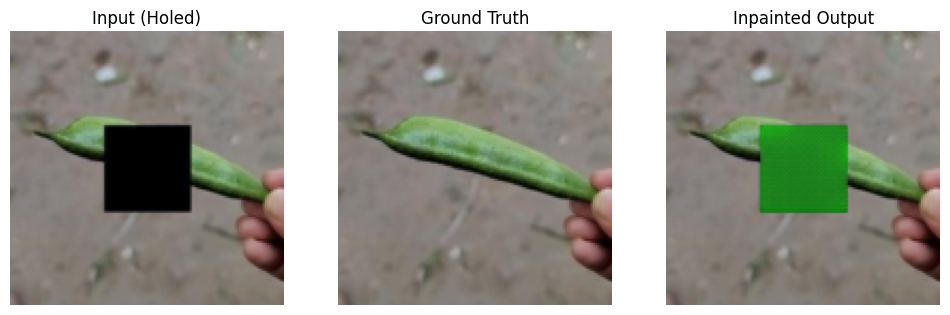

In [38]:


# Visualize the results
visualize_inpainting(test_loader, model)


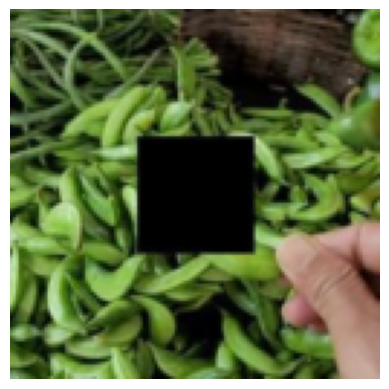

In [39]:
import matplotlib.pyplot as plt

for combined_input, target in test_loader:
    input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()
    input_image = (input_image * 255).astype(np.uint8)

    plt.imshow(input_image[0])  # Visualize the first image
    plt.axis("off")
    plt.show()
    break


In [40]:
# Helper function to compute PSNR
def compute_psnr(output, target):
    mse = np.mean((output - target) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if there's no error
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [41]:
def evaluate_model(test_loader, model, selected_loss, log_to_mlflow=True):
    """
    Evaluate the model using the selected loss function.

    Args:
        test_loader (DataLoader): DataLoader for the test dataset.
        model (nn.Module): Trained inpainting model.
        selected_loss (str): Loss function name ("MSE", "MAE", "Perceptual").
        log_to_mlflow (bool): Whether to log metrics to MLflow.

    Returns:
        dict: Evaluation results.
    """
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0  # For computing PSNR

    num_batches = len(test_loader)
    total_images = num_batches * test_loader.batch_size

    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            mask = combined_input[:, 3:4, :, :]  # Extract the mask
            output = model(combined_input)

            # Compute the selected loss dynamically
            if selected_loss == "MSE":
                loss = masked_loss(output, target, mask)
            elif selected_loss == "MAE":
                loss = masked_loss(mae_loss(output, target), target, mask)
            elif selected_loss == "Perceptual":
                normalized_output = (output - 0.5) * 2
                normalized_target = (target - 0.5) * 2
                loss = perceptual_loss(normalized_output, normalized_target)

            total_loss += loss.item()

            # Compute PSNR
            output_np = (output.cpu().numpy() * 255).astype(np.uint8)
            target_np = (target.cpu().numpy() * 255).astype(np.uint8)
            for b in range(output_np.shape[0]):
                psnr = compute_psnr(output_np[b], target_np[b])
                total_psnr += psnr

    avg_loss = total_loss / num_batches
    avg_psnr = total_psnr / total_images

    # Log results to MLflow
    if log_to_mlflow:
        mlflow.log_metric(f"{selected_loss} Test Loss", avg_loss)
        mlflow.log_metric(f"{selected_loss} Test PSNR", avg_psnr)

    print(f"Test Loss ({selected_loss}): {avg_loss:.4f}")
    print(f"Test PSNR ({selected_loss}): {avg_psnr:.4f}")

    return {"test_loss": avg_loss, "test_psnr": avg_psnr}


In [42]:
with open("mlflow_run_id.txt", "r") as f:
    run_id = f.read().strip()

# Continue the run or start logging to the same run
with mlflow.start_run(run_id=run_id):

# Evaluate the model
    evaluation_results = evaluate_model(test_loader, model, selected_loss)
mlflow.end_run()

Test Loss (Perceptual): 0.0780
Test PSNR (Perceptual): 22.5466
